In [5]:
# Importing the required libraries
import geopandas as gpd
import pandas as pd
import rioxarray
import rasterio as rio
import xarray as xr
from pystac_client import Client
from datetime import datetime
from shapely.geometry import Point, Polygon, shape, box
import geopandas as gpd
import numpy as np
import stackstac
from dask.distributed import Client as c

In [3]:
# Selecting the locatiom
long_lat = (77.59722233643667, 12.95646688363659)
poi = Point(long_lat)

In [4]:
# Initialize STAC Client
import planetary_computer
api_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = Client.open(api_url,modifier=planetary_computer.sign_inplace)

# Define parameters
start_date = "2023-06-01"
end_date = "2024-12-10"
collections = ["sentinel-2-l2a", "landsat-c2-l2"]

# Search both collections
search = catalog.search(
    collections=collections,
    datetime=f"{start_date}/{end_date}",
    intersects = poi,
    max_items=100,query={"eo:cloud_cover": {"lt": 10}},
)
items = list(search.items())

In [5]:
# for i in catalog.get_all_collections():
#     print(i)

In [6]:
results = []

# Process items
for item in items:
    date = datetime.fromisoformat(item.properties["datetime"]).strftime("%Y-%m-%d")
    results.append({
        "date": date,
        "satellite": "Sentinel-2" if "sentinel" in item.collection_id else "Landsat-8",
        "scene_id": item.id,
        "geometry": shape(item.geometry),
        "collection": item.collection_id
    })

# Create DataFrame
df = pd.DataFrame(results)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# Find overlapping scenes
overlapping_pairs = []
sentinel_gdf = gdf[gdf["satellite"] == "Sentinel-2"]
landsat_gdf = gdf[gdf["satellite"] == "Landsat-8"]

for _, s2_row in sentinel_gdf.iterrows():
    for _, l8_row in landsat_gdf.iterrows():
        if s2_row["date"] == l8_row["date"]:
            if s2_row.geometry.intersects(l8_row.geometry):
                intersection = s2_row.geometry.intersection(l8_row.geometry)
                overlapping_pairs.append({
                    "date": s2_row["date"],
                    "sentinel_id": s2_row["scene_id"],
                    "landsat_id": l8_row["scene_id"],
                    "geometry": intersection
                })

# Create final GeoDataFrame
overlap_gdf = gpd.GeoDataFrame(
    overlapping_pairs,
    geometry="geometry",
    crs="EPSG:4326"
).sort_values("date").reset_index(drop=True)

# Add area in km² column
overlap_gdf["area_km2"] = overlap_gdf.to_crs("EPSG:3857").geometry.area / 10**6

# Selecting AOI with maximum overlap
Final_aoi = overlap_gdf[overlap_gdf["area_km2"]==overlap_gdf["area_km2"].max()]

# Display results
print(f"Found {len(overlap_gdf)} overlapping pairs")
print(overlap_gdf[["date", "sentinel_id", "landsat_id", "area_km2"]])

Found 3 overlapping pairs
         date                                        sentinel_id  \
0  2024-02-07  S2A_MSIL2A_20240207T051001_R019_T43PGQ_2024020...   
1  2024-03-18  S2A_MSIL2A_20240318T050651_R019_T43PGQ_2024031...   
2  2024-04-27  S2A_MSIL2A_20240427T050651_R019_T43PGQ_2024042...   

                        landsat_id      area_km2  
0  LC08_L2SP_144051_20240207_02_T1  12565.205274  
1  LC09_L2SP_144051_20240318_02_T1  12646.282804  
2  LC08_L2SP_144051_20240427_02_T1  12654.212918  


In [ ]:
# Creating 500 random sample points over the intersecting AOI
aoi200_sampled_points = Final_aoi.sample_points(500).explode(index_parts=True).reset_index(drop=True)
m = Final_aoi.explore()
aoi200_sampled_points.explore(m=m, color='red')

In [8]:
# Searching Sentinel collection
search = catalog.search(
    collections=collections[0],
    datetime=f"{start_date}/{end_date}",
    intersects = poi,
)
sentinel_items = list(search.items())

In [9]:
# Searching Landsat collection
search = catalog.search(
collections=collections[1],
datetime=f"{start_date}/{end_date}",
    intersects = poi,
)
landsat_items = list(search.items())

In [10]:
# Fetching the UTM crs
crs = int(Final_aoi.estimate_utm_crs().to_string().split(':')[1])

In [ ]:
# Data with maximum overlap
coinciding_date = Final_aoi.date.values[0]

In [12]:
# Converting the collection to STAC
sentinel_stack = stackstac.stack(sentinel_items,resolution=10,rescale=False,fill_value=np.nan,epsg=crs).rio.clip(Final_aoi.geometry.values, Final_aoi.crs)
landsat_stack = stackstac.stack(landsat_items, rescale=False,fill_value=np.nan,epsg=crs).rio.clip(Final_aoi.geometry.values, Final_aoi.crs)

In [13]:
# Formula for converting DN to temperature
# ST = (DN * 0.00341802) + 149.0

In [ ]:
# Bands
landsat_bands = ['lwir11']
sentinel_bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
       'B11', 'B12', 'B8A']

In [ ]:
# Selecting the Multispectrals Bands interesecting with the date from both collection
landsat_stack_sub = (landsat_stack.sel(time=coinciding_date).sel(band=landsat_bands).squeeze(dim='time').compute() * 0.00341802) + 149.0
sentinel_stack_sub = sentinel_stack.sel(time=coinciding_date,band=sentinel_bands).squeeze(dim='time').compute()

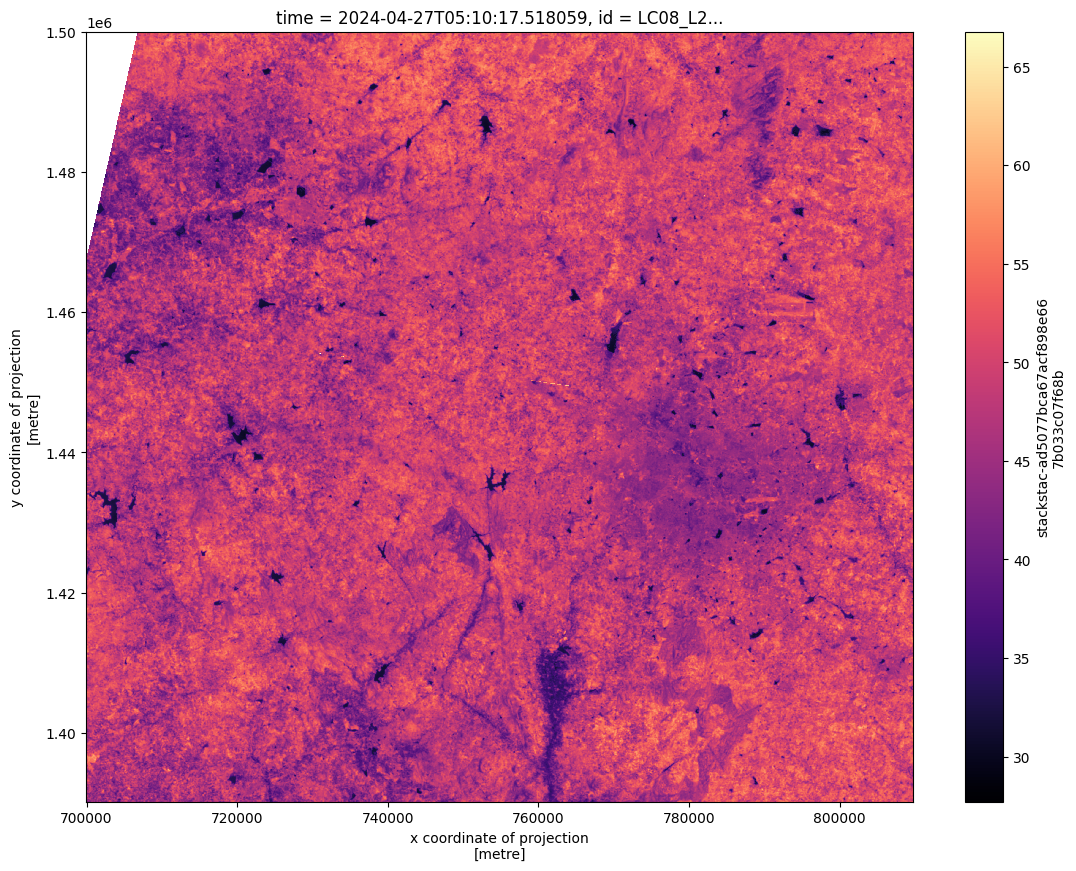

In [ ]:
# Kelvin to celsius conversion
celsius = landsat_stack_sub - 273.15
celsius.plot(cmap="magma", size=10);

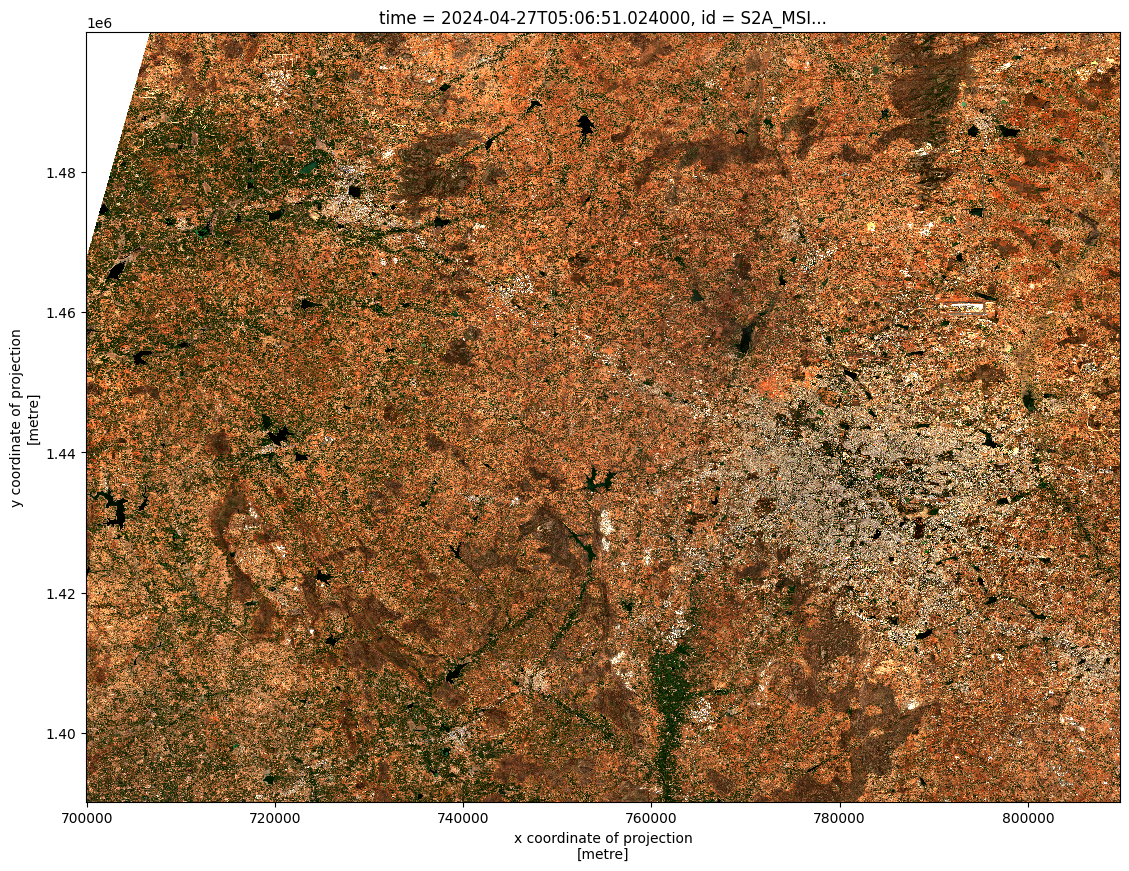

In [21]:
sentinel_stack_sub.sel(band=['B04','B03','B02']).plot.imshow(robust=True, size=10)

In [6]:
def point_sampling(ponits:gpd.GeoDataFrame,band:xr.DataArray) ->gpd.GeoDataFrame:
    crs = band.rio.crs
    
    # 1. Project the points to right CRS
    ponits = ponits.to_crs(crs)

    # 2. Fetch the X amd Y cordinates
    x_coords = ponits.geometry.x
    y_coords = ponits.geometry.y

    # 3. Get the list of band names (assumes `sentinel_stack_sub` has a 'band' coordinate)
    band_names = list(band.band.values)

    # 4. Loop over each point, sample all bands using `.sel(x=…, y=…, method="nearest")`
    sampled_values = []
    for x, y in zip(x_coords, y_coords):
        # This returns a 1D numpy array of shape (n_bands,) for that (x,y)
        vals = band.sel(x=x, y=y, method="nearest").values
        sampled_values.append(vals)

    # 5. Build a DataFrame: rows = points, columns = band names
    df = pd.DataFrame(sampled_values, columns=band_names)

    # 6. (Optional) Attach the original geometry back onto the table
    df['geometry'] = aoi200_sampled_points.geometry.values

    # 7. If you want a GeoDataFrame instead of a plain DataFrame:
    gdf_samples = gpd.GeoDataFrame(df, geometry='geometry', crs=sentinel_stack_sub.rio.crs)


    # Example: inspect the first few rows
    print(gdf_samples.head())

    return gdf_samples

In [17]:
# Sampling the thermal band from landsat
themperature_df = point_sampling(aoi200_sampled_points,landsat_stack_sub)

       lwir11               geometry
0  317.921966  POINT (76.841 12.639)
1  318.749127  POINT (76.845 12.862)
2  321.678370   POINT (76.85 13.081)
3  314.767134  POINT (76.857 13.165)
4  319.087511  POINT (76.859 12.662)


In [18]:
# Sampling the Sentinel bands
sampled_bands = []
for band in sentinel_bands:
    band_df = point_sampling(aoi200_sampled_points,sentinel_stack_sub.sel(band=[band]))
    sampled_bands.append(band_df[[band]])

      B01               geometry
0  1380.0  POINT (76.841 12.639)
1  1501.0  POINT (76.845 12.862)
2  1617.0   POINT (76.85 13.081)
3  1251.0  POINT (76.857 13.165)
4  1298.0  POINT (76.859 12.662)
      B02               geometry
0  1407.0  POINT (76.841 12.639)
1  1844.0  POINT (76.845 12.862)
2  1689.0   POINT (76.85 13.081)
3  1310.0  POINT (76.857 13.165)
4  1298.0  POINT (76.859 12.662)
      B03               geometry
0  1817.0  POINT (76.841 12.639)
1  2268.0  POINT (76.845 12.862)
2  2182.0   POINT (76.85 13.081)
3  1670.0  POINT (76.857 13.165)
4  1786.0  POINT (76.859 12.662)
      B04               geometry
0  1646.0  POINT (76.841 12.639)
1  2560.0  POINT (76.845 12.862)
2  3322.0   POINT (76.85 13.081)
3  1719.0  POINT (76.857 13.165)
4  1720.0  POINT (76.859 12.662)
      B05               geometry
0  2278.0  POINT (76.841 12.639)
1  2777.0  POINT (76.845 12.862)
2  3839.0   POINT (76.85 13.081)
3  2233.0  POINT (76.857 13.165)
4  2225.0  POINT (76.859 12.662)
      B06 

In [ ]:
sampled_bands = pd.concat(sampled_bands,axis=1)

In [20]:
sampled_bands.head(5)

B01     B02     B03     B04     B05     B06     B07     B08     B09  \
0  1380.0  1407.0  1817.0  1646.0  2278.0  3673.0  4144.0  4516.0  4465.0   
1  1501.0  1844.0  2268.0  2560.0  2777.0  3600.0  3865.0  4256.0  3381.0   
2  1617.0  1689.0  2182.0  3322.0  3839.0  4111.0  4298.0  4212.0  4374.0   
3  1251.0  1310.0  1670.0  1719.0  2233.0  3578.0  3954.0  4128.0  4400.0   
4  1298.0  1298.0  1786.0  1720.0  2225.0  3858.0  4478.0  4504.0  4497.0   

      B11     B12     B8A  
0  3641.0  2732.0  4350.0  
1  4672.0  3703.0  4291.0  
2  6170.0  4916.0  4414.0  
3  3288.0  2279.0  4324.0  
4  3740.0  2571.0  4700.0

In [ ]:
# Combining independ bands and the depend band (temperature)
final_ds = pd.concat([themperature_df,sampled_bands],axis=1).rename(columns = {'lwir11':'temperature'})

In [25]:
final_ds.to_file(r'D:\DeepLearning\Projects\temperature_at10m\Data\temperature_downcaling_data.geojson')